In [1]:
import kagglehub

path = kagglehub.dataset_download("nuranfarhanaprova/processed-rice-varieties-of-bangladesh")

print("Path to dataset files:", path)

100%|██████████| 240M/240M [00:06<00:00, 39.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


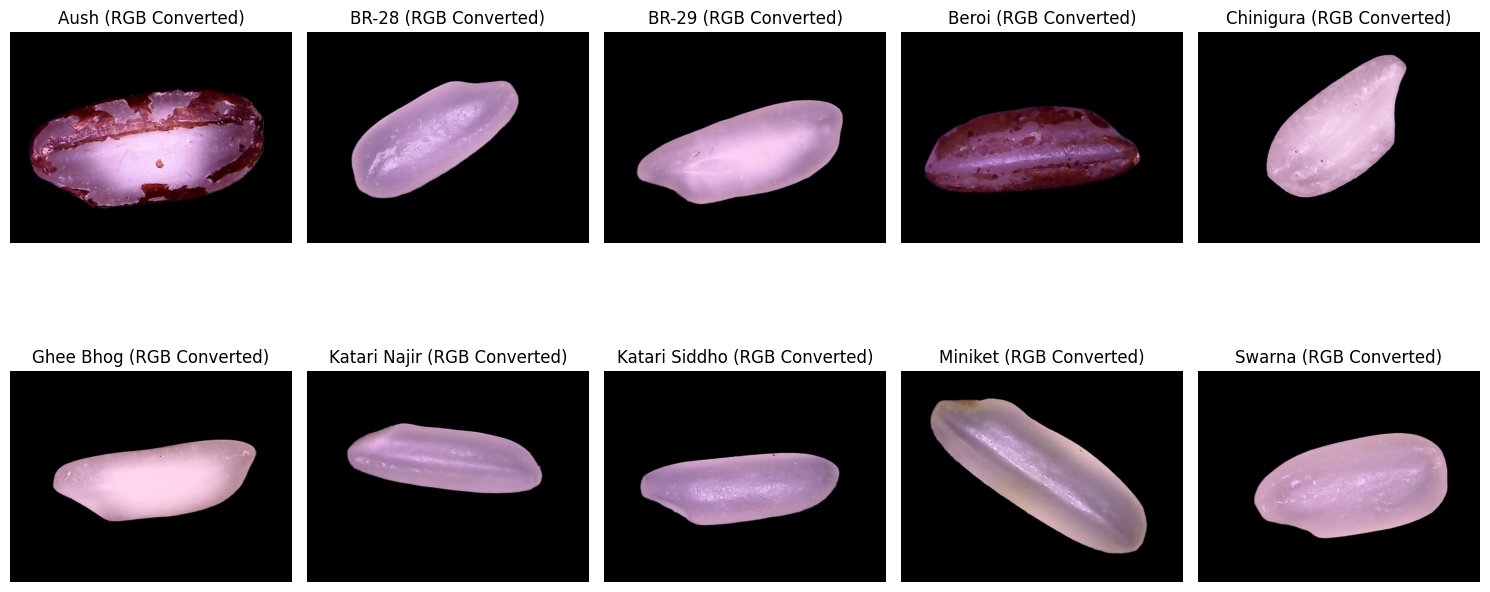

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ---------- Function: RGBe → RGB (smooth, non-binary) ----------
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# ---------- Folder paths ----------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
import os
import shutil
import numpy as np

# -----------------------------
# Paths
# -----------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
split_base_dir = '/kaggle/working/split_data_70_30'

# -----------------------------
# Prepare directories
# -----------------------------
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

# Clear previous split (optional)
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# -----------------------------
# Perform split
# -----------------------------
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)

    total = len(images)

    # Step 1: 70:30 train:test
    train_val_end = int(total * 0.7)
    train_val_images = images[:train_val_end]
    test_images = images[train_val_end:]

    # Step 2: Within training portion, 10% for validation
    val_end = int(len(train_val_images) * 0.1)
    val_images = train_val_images[:val_end]
    train_images = train_val_images[val_end:]

    # Mapping
    split_images = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }

    # Copy images
    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# -----------------------------
# Print split summary
# -----------------------------
print("Dataset Split Summary (number of images per class):\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()


Dataset Split Summary (number of images per class):

--- TRAIN ---
Aush: 126
BR-28: 126
BR-29: 126
Miniket: 126
Swarna: 126
Katari Najir: 126
Ghee Bhog: 126
Chinigura: 126
Katari Siddho: 126
Beroi: 126

--- VAL ---
Aush: 14
BR-28: 14
BR-29: 14
Miniket: 14
Swarna: 14
Katari Najir: 14
Ghee Bhog: 14
Chinigura: 14
Katari Siddho: 14
Beroi: 14

--- TEST ---
Aush: 60
BR-28: 60
BR-29: 60
Miniket: 60
Swarna: 60
Katari Najir: 60
Ghee Bhog: 60
Chinigura: 60
Katari Siddho: 60
Beroi: 60



Found 1260 images belonging to 10 classes.
Found 140 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 - 131s - 3s/step - accuracy: 0.5595 - loss: 1.3050 - val_accuracy: 0.7500 - val_loss: 0.8198 - learning_rate: 1.0000e-03
Epoch 2/40
40/40 - 13s - 317ms/step - accuracy: 0.7587 - loss: 0.7428 - val_accuracy: 0.7286 - val_loss: 0.6776 - learning_rate: 1.0000e-03
Epoch 3/40
40/40 - 12s - 296ms/step - accuracy: 0.7873 - loss: 0.6168 - val_accuracy: 0.8071 - val_loss: 0.5929 - learning_rate: 1.0000e-03
Epoch 4/40
40/40 - 12s - 298ms/step - accuracy: 0.8278 - loss: 0.5189 - val_accuracy: 0.8429 - val_loss: 0.5460 - learning_rate: 1.0000e-03
Epoch 5/40
40/40 - 20s - 512ms/step - accuracy: 0.8730 - loss: 0.4531 - val_accuracy: 0.8714 - val_loss: 0.4826 - learning_rate: 1.0000e-03
Epoch 6/40
40/40 - 12s - 298ms/step - accuracy: 0.8817 - loss: 0.3883 - val_accuracy: 0.8500 - val_loss: 0.5136 - learning_rate: 1.0000e-03
Epoch 7/40
40/40 - 12s - 297ms/step - accuracy: 0.8873 - loss: 0.3894 - val_accuracy: 0.8429 - val_loss: 0.4608 - learning_rate: 1.0000e-03
Epoch 8/40
40/40 - 12s

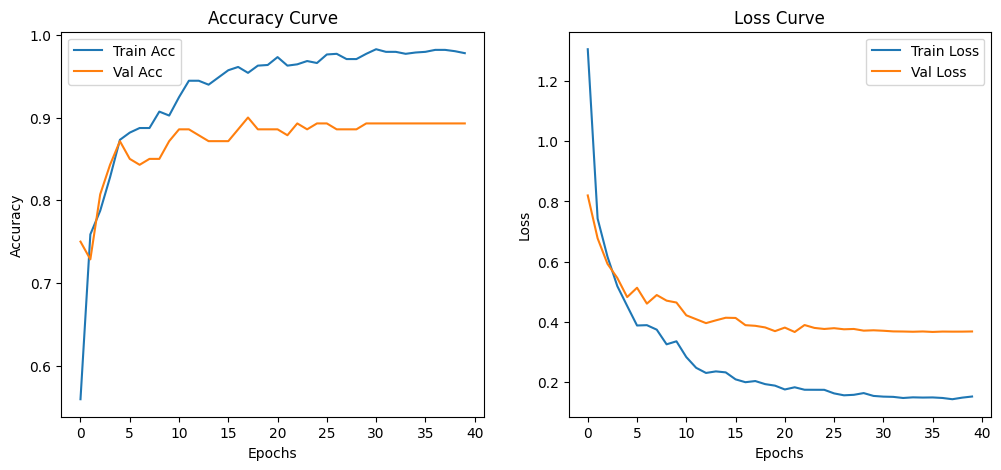


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    0.9667    0.9831        60
        BR-28     0.8824    0.7500    0.8108        60
        BR-29     0.8966    0.8667    0.8814        60
      Miniket     0.9836    1.0000    0.9917        60
       Swarna     0.9672    0.9833    0.9752        60
 Katari Najir     0.9273    0.8500    0.8870        60
    Ghee Bhog     0.7937    0.8333    0.8130        60
    Chinigura     0.8154    0.8833    0.8480        60
Katari Siddho     0.9194    0.9500    0.9344        60
        Beroi     0.8636    0.9500    0.9048        60

     accuracy                         0.9033       600
    macro avg     0.9049    0.9033    0.9029       600
 weighted avg     0.9049    0.9033    0.9029       600



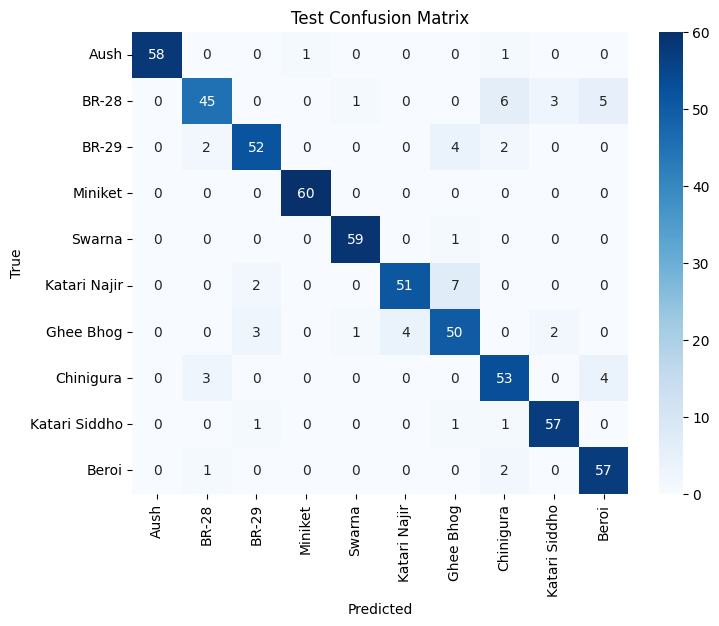

Aush Accuracy: 0.9667
BR-28 Accuracy: 0.7500
BR-29 Accuracy: 0.8667
Miniket Accuracy: 1.0000
Swarna Accuracy: 0.9833
Katari Najir Accuracy: 0.8500
Ghee Bhog Accuracy: 0.8333
Chinigura Accuracy: 0.8833
Katari Siddho Accuracy: 0.9500
Beroi Accuracy: 0.9500
Test AUC: 0.9927
Test PR AUC: 0.9552

Training Time: 617.59 seconds


In [5]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
split_base_dir = '/kaggle/working/split_data_70_30'
img_size = (224, 224)
batch_size = 32
num_classes = len([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


In [6]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.083600 seconds


In [7]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,816,030
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.9049
Macro Recall: 0.9033
Macro F1-score: 0.9029
Aush: Precision=1.0000, Recall=0.9667, F1=0.9831
BR-28: Precision=0.8824, Recall=0.7500, F1=0.8108
BR-29: Precision=0.8966, Recall=0.8667, F1=0.8814
Miniket: Precision=0.9836, Recall=1.0000, F1=0.9917
Swarna: Precision=0.9672, Recall=0.9833, F1=0.9752
Katari Najir: Precision=0.9273, Recall=0.8500, F1=0.8870
Ghee Bhog: Precision=0.7937, Recall=0.8333, F1=0.8130
Chinigura: Precision=0.8154, Recall=0.8833, F1=0.8480
Katari Siddho: Precision=0.9194, Recall=0.9500, F1=0.9344
Beroi: Precision=0.8636, Recall=0.9500, F1=0.9048


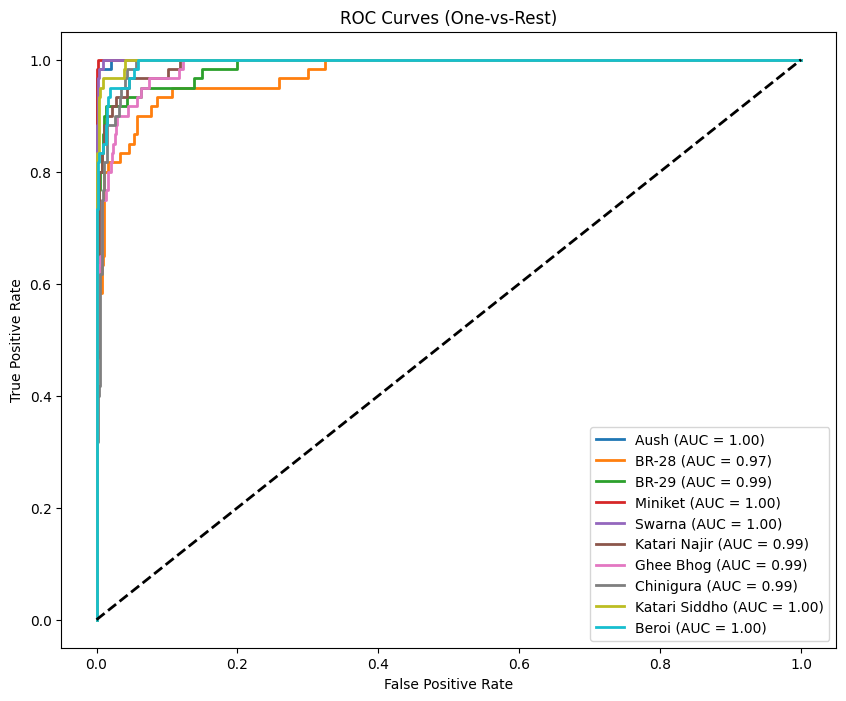

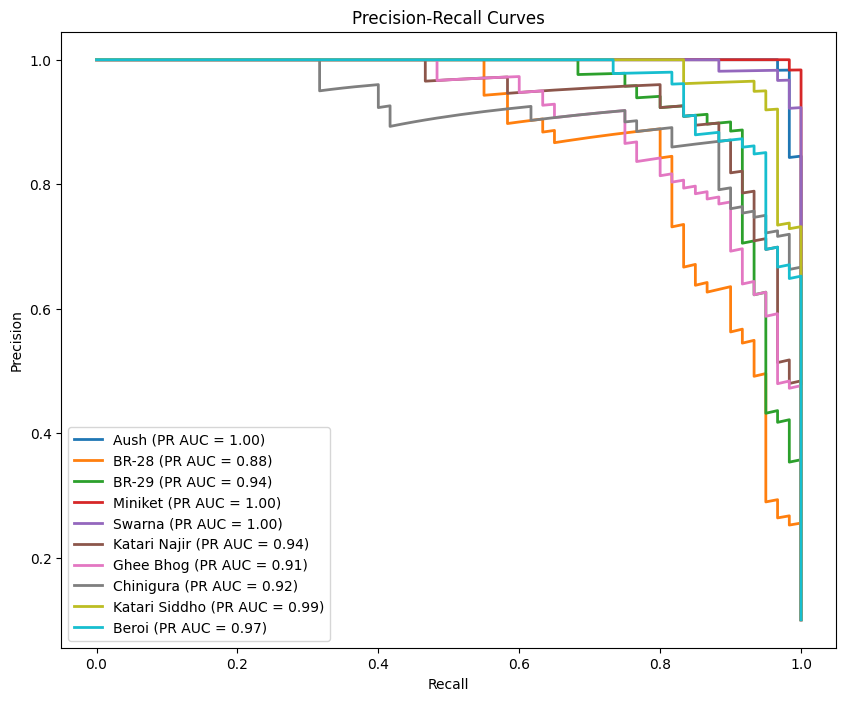

Total inference time: 5.54 sec
Inference time per sample: 0.009240 sec

Most confused class pairs:
Aush is most often confused with Miniket (1 samples)
BR-28 is most often confused with Chinigura (6 samples)
BR-29 is most often confused with Ghee Bhog (4 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with Ghee Bhog (1 samples)
Katari Najir is most often confused with Ghee Bhog (7 samples)
Ghee Bhog is most often confused with Katari Najir (4 samples)
Chinigura is most often confused with Beroi (4 samples)
Katari Siddho is most often confused with BR-29 (1 samples)
Beroi is most often confused with Chinigura (2 samples)


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

Found 1260 images belonging to 10 classes.
Found 140 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 - 43s - 1s/step - accuracy: 0.2563 - loss: 2.1442 - val_accuracy: 0.4214 - val_loss: 1.6965 - learning_rate: 1.0000e-03
Epoch 2/40
40/40 - 12s - 310ms/step - accuracy: 0.4817 - loss: 1.5113 - val_accuracy: 0.6000 - val_loss: 1.3445 - learning_rate: 1.0000e-03
Epoch 3/40
40/40 - 12s - 306ms/step - accuracy: 0.5587 - loss: 1.3086 - val_accuracy: 0.6071 - val_loss: 1.2736 - learning_rate: 1.0000e-03
Epoch 4/40
40/40 - 12s - 308ms/step - accuracy: 0.5706 - loss: 1.2138 - val_accuracy: 0.5643 - val_loss: 1.2105 - learning_rate: 1.0000e-03
Epoch 5/40
40/40 - 13s - 313ms/step - accuracy: 0.6206 - loss: 1.1079 - val_accuracy: 0.5857 - val_loss: 1.1234 - learning_rate: 1.0000e-03
Epoch 6/40
40/40 - 12s - 310ms/step - accuracy: 0.6587 - loss: 1.0359 - val_accuracy: 0.6429 - val_loss: 1.0782 - learning_rate: 1.0000e-03
Epoch 7/40
40/40 - 12s - 311ms/step - accuracy: 0.6651 - loss: 0.9782 - val_accuracy: 0.6500 - val_loss: 0.9996 - learning_rate: 1.0000e-03
Epoch 8/40
40/40 - 14s 

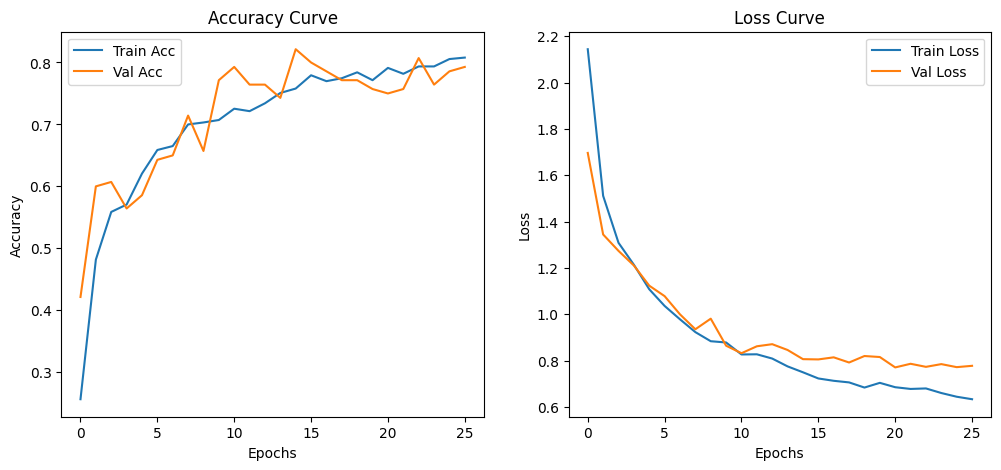


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.7833    0.7833    0.7833        60
        BR-28     0.7442    0.5333    0.6214        60
        BR-29     0.5417    0.6500    0.5909        60
      Miniket     0.7273    0.8000    0.7619        60
       Swarna     0.8387    0.8667    0.8525        60
 Katari Najir     0.6447    0.8167    0.7206        60
    Ghee Bhog     0.8065    0.4167    0.5495        60
    Chinigura     0.7656    0.8167    0.7903        60
Katari Siddho     0.8750    0.9333    0.9032        60
        Beroi     0.8065    0.8333    0.8197        60

     accuracy                         0.7450       600
    macro avg     0.7533    0.7450    0.7393       600
 weighted avg     0.7533    0.7450    0.7393       600



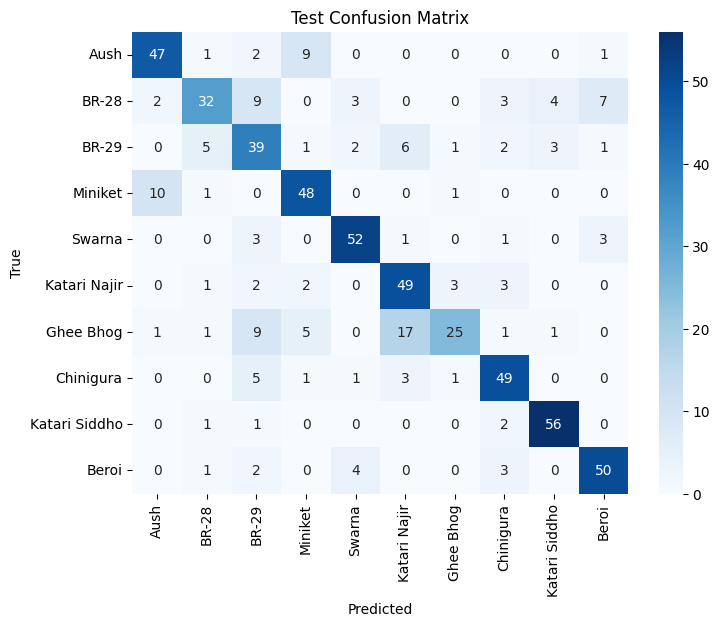

Aush Accuracy: 0.7833
BR-28 Accuracy: 0.5333
BR-29 Accuracy: 0.6500
Miniket Accuracy: 0.8000
Swarna Accuracy: 0.8667
Katari Najir Accuracy: 0.8167
Ghee Bhog Accuracy: 0.4167
Chinigura Accuracy: 0.8167
Katari Siddho Accuracy: 0.9333
Beroi Accuracy: 0.8333
Test AUC: 0.9664
Test PR AUC: 0.8136

Training Time: 353.83 seconds


In [12]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_70_30'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"  # Update if needed
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: ConvNeXtTiny
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")

In [13]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.023559 seconds


In [14]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.7533
Macro Recall: 0.7450
Macro F1-score: 0.7393
Aush: Precision=0.7833, Recall=0.7833, F1=0.7833
BR-28: Precision=0.7442, Recall=0.5333, F1=0.6214
BR-29: Precision=0.5417, Recall=0.6500, F1=0.5909
Miniket: Precision=0.7273, Recall=0.8000, F1=0.7619
Swarna: Precision=0.8387, Recall=0.8667, F1=0.8525
Katari Najir: Precision=0.6447, Recall=0.8167, F1=0.7206
Ghee Bhog: Precision=0.8065, Recall=0.4167, F1=0.5495
Chinigura: Precision=0.7656, Recall=0.8167, F1=0.7903
Katari Siddho: Precision=0.8750, Recall=0.9333, F1=0.9032
Beroi: Precision=0.8065, Recall=0.8333, F1=0.8197


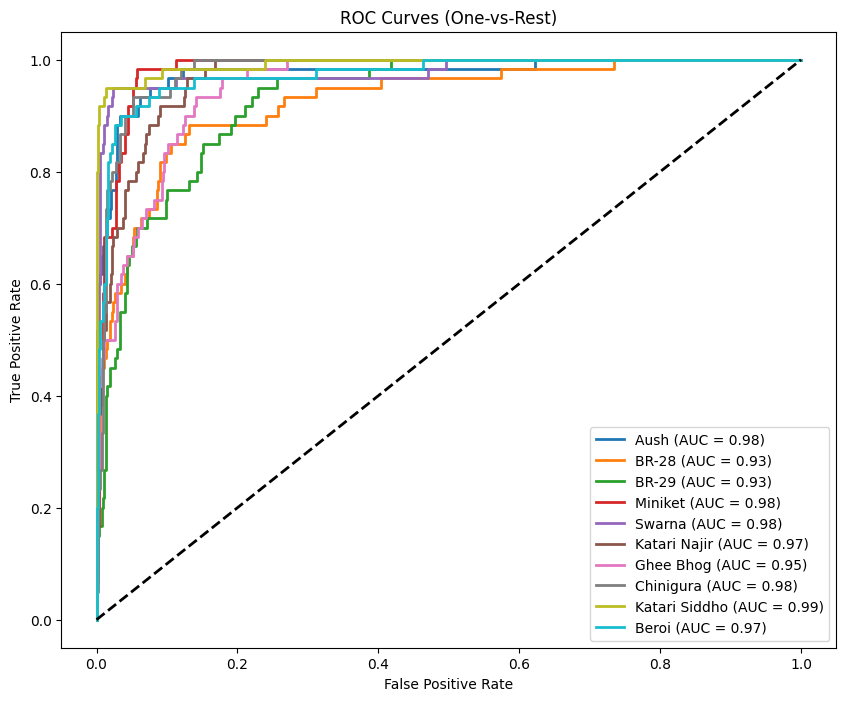

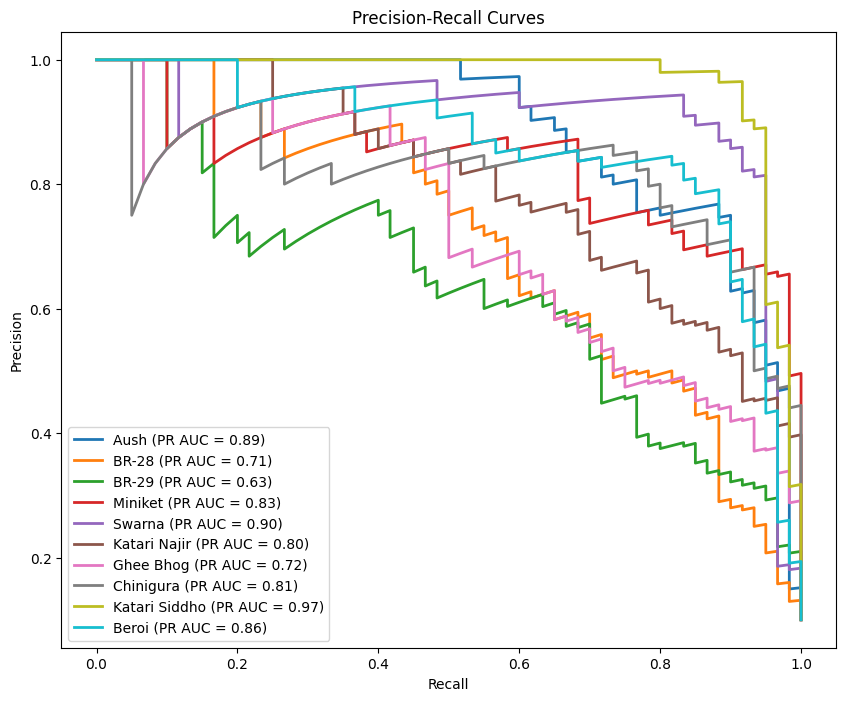

Total inference time: 5.52 sec
Inference time per sample: 0.009202 sec

Most confused class pairs:
Aush is most often confused with Miniket (9 samples)
BR-28 is most often confused with BR-29 (9 samples)
BR-29 is most often confused with Katari Najir (6 samples)
Miniket is most often confused with Aush (10 samples)
Swarna is most often confused with BR-29 (3 samples)
Katari Najir is most often confused with Ghee Bhog (3 samples)
Ghee Bhog is most often confused with Katari Najir (17 samples)
Chinigura is most often confused with BR-29 (5 samples)
Katari Siddho is most often confused with Chinigura (2 samples)
Beroi is most often confused with Swarna (4 samples)


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


Found 1260 images belonging to 10 classes.
Found 140 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 - 53s - 1s/step - accuracy: 0.6024 - loss: 1.2482 - val_accuracy: 0.7857 - val_loss: 0.6565 - learning_rate: 1.0000e-03
Epoch 2/40
40/40 - 15s - 376ms/step - accuracy: 0.8310 - loss: 0.5734 - val_accuracy: 0.8500 - val_loss: 0.5326 - learning_rate: 1.0000e-03
Epoch 3/40
40/40 - 14s - 343ms/step - accuracy: 0.8635 - loss: 0.4571 - val_accuracy: 0.8143 - val_loss: 0.5520 - learning_rate: 1.0000e-03
Epoch 4/40
40/40 - 14s - 346ms/step - accuracy: 0.8738 - loss: 0.4157 - val_accuracy: 0.8643 - val_loss: 0.4299 - learning_rate: 1.0000e-03
Epoch 5/40
40/40 - 14s - 341ms/step - accuracy: 0.8865 - loss: 0.3640 - val_accuracy: 0.8143 - val_loss: 0.5566 - learning_rate: 1.0000e-03
Epoch 6/40
40/40 - 14s - 345ms/step - accuracy: 0.9222 - loss: 0.3136 - val_accuracy: 0.9071 - val_loss: 0.3692 - learning_rate: 1.0000e-03
Epoch 7/40
40/40 - 14s - 347ms/step - accuracy: 0.9310 - loss: 0.2671 - val_accuracy: 0.9000 - val_loss: 0.3631 - learning_rate: 1.0000e-03
Epoch 8/40
40/40 - 14s 

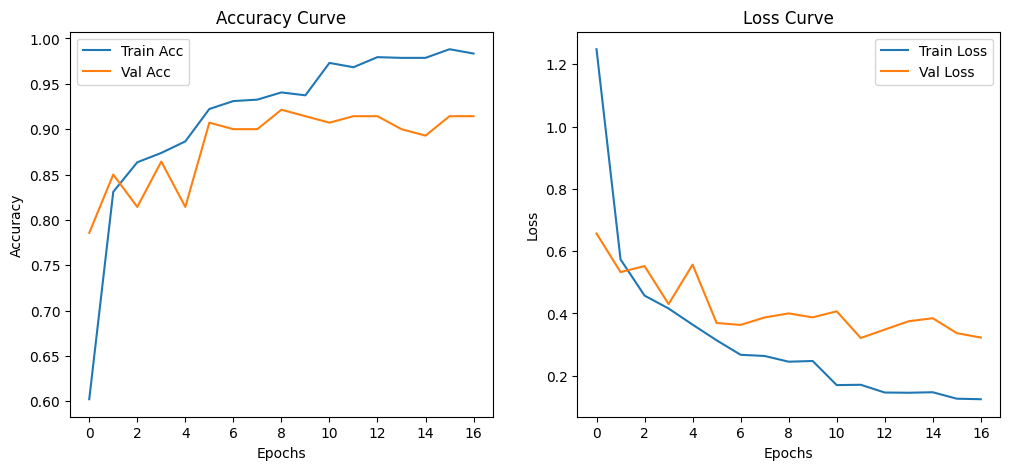


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.9821    0.9167    0.9483        60
        BR-28     0.8276    0.8000    0.8136        60
        BR-29     0.9500    0.9500    0.9500        60
      Miniket     0.9219    0.9833    0.9516        60
       Swarna     0.9077    0.9833    0.9440        60
 Katari Najir     0.9245    0.8167    0.8673        60
    Ghee Bhog     0.8000    0.8667    0.8320        60
    Chinigura     0.8689    0.8833    0.8760        60
Katari Siddho     0.9831    0.9667    0.9748        60
        Beroi     0.9153    0.9000    0.9076        60

     accuracy                         0.9067       600
    macro avg     0.9081    0.9067    0.9065       600
 weighted avg     0.9081    0.9067    0.9065       600



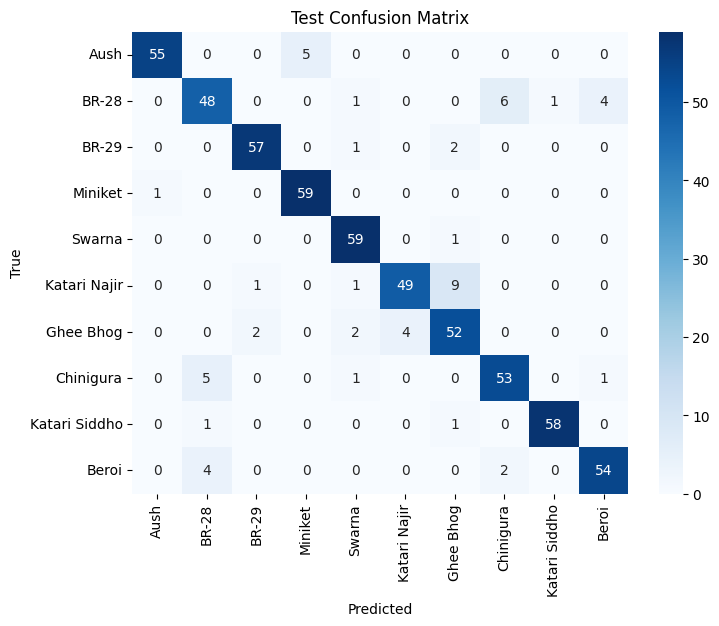

Aush Accuracy: 0.9167
BR-28 Accuracy: 0.8000
BR-29 Accuracy: 0.9500
Miniket Accuracy: 0.9833
Swarna Accuracy: 0.9833
Katari Najir Accuracy: 0.8167
Ghee Bhog Accuracy: 0.8667
Chinigura Accuracy: 0.8833
Katari Siddho Accuracy: 0.9667
Beroi Accuracy: 0.9000
Macro Precision: 0.9081
Macro Recall: 0.9067
Macro F1-score: 0.9065
Aush: Precision=0.9821, Recall=0.9167, F1=0.9483
BR-28: Precision=0.8276, Recall=0.8000, F1=0.8136
BR-29: Precision=0.9500, Recall=0.9500, F1=0.9500
Miniket: Precision=0.9219, Recall=0.9833, F1=0.9516
Swarna: Precision=0.9077, Recall=0.9833, F1=0.9440
Katari Najir: Precision=0.9245, Recall=0.8167, F1=0.8673
Ghee Bhog: Precision=0.8000, Recall=0.8667, F1=0.8320
Chinigura: Precision=0.8689, Recall=0.8833, F1=0.8760
Katari Siddho: Precision=0.9831, Recall=0.9667, F1=0.9748
Beroi: Precision=0.9153, Recall=0.9000, F1=0.9076


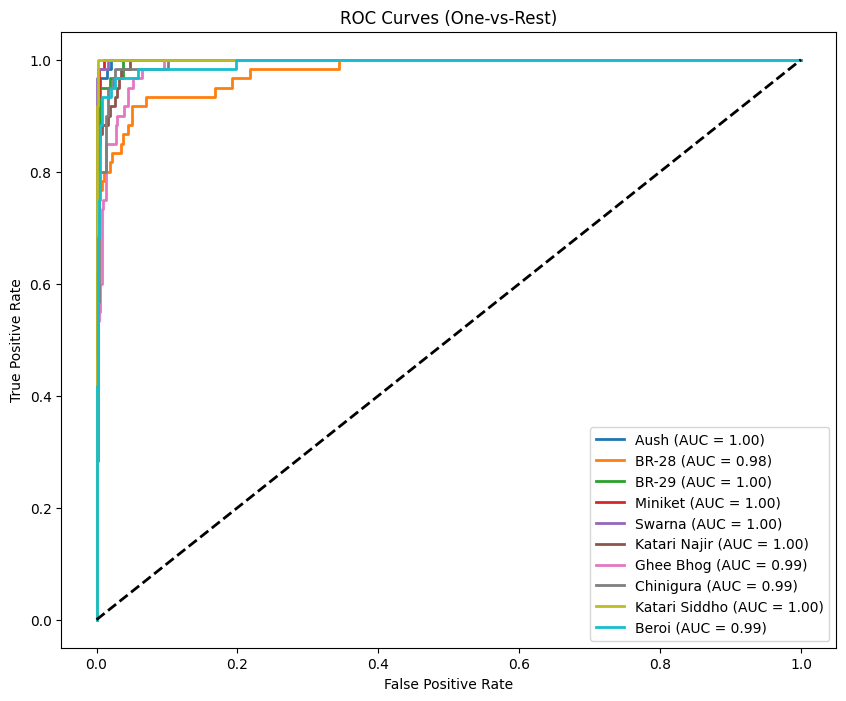

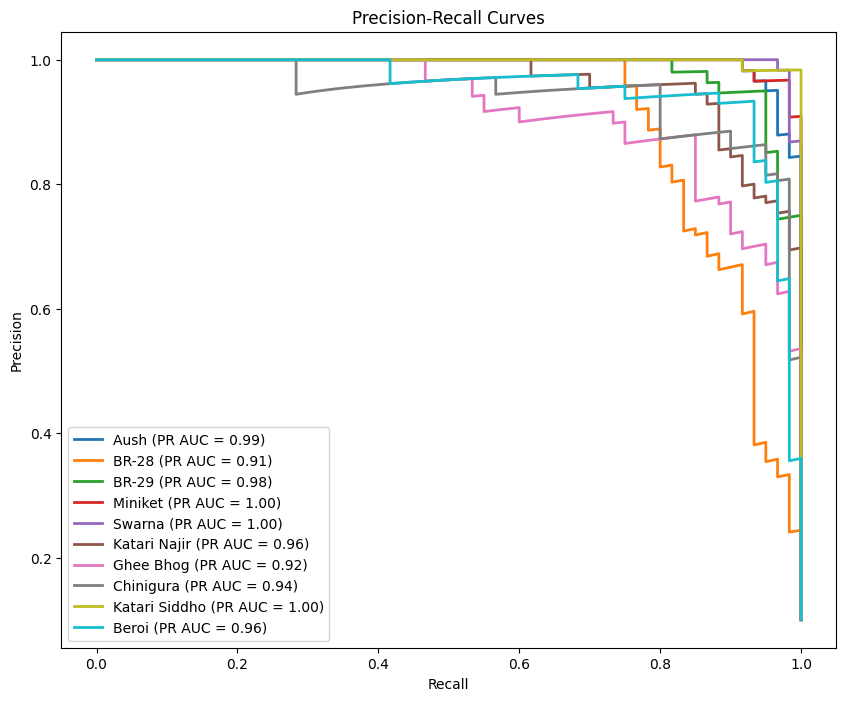

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 19.72 sec
Inference time per sample: 0.032871 sec

Most confused class pairs:
Aush is most often confused with Miniket (5 samples)
BR-28 is most often confused with Chinigura (6 samples)
BR-29 is most often confused with Ghee Bhog (2 samples)
Miniket is most often confused with Aush (1 samples)
Swarna is most often confused with Ghee Bhog (1 samples)
Katari Najir is most often confused with Ghee Bhog (9 samples)
Ghee Bhog is most often confused with Katari Najir (4 samples)
Chinigura is most often confused with BR-28 (5 samples)
Katari Siddho is most often confused with BR-28 (1 samples)
Beroi is most often confused with BR-28 (4 samples)


In [17]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_70_30'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (299, 299)  # InceptionV3 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: InceptionV3
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

inception_model = build_inception_model(num_classes=num_classes)
inception_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = inception_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, inception_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, inception_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, inception_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = inception_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

In [18]:
start_test = time.time()
_ = inception_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.018000 seconds


In [19]:
# Calculate and print the number of parameters
total_params = inception_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 22,857,002
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Found 1260 images belonging to 10 classes.
Found 140 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 - 36s - 907ms/step - accuracy: 0.2500 - loss: 2.1816 - val_accuracy: 0.3571 - val_loss: 1.8612 - learning_rate: 1.0000e-03
Epoch 2/40
40/40 - 12s - 301ms/step - accuracy: 0.3683 - loss: 1.7492 - val_accuracy: 0.4286 - val_loss: 1.6405 - learning_rate: 1.0000e-03
Epoch 3/40
40/40 - 12s - 305ms/step - accuracy: 0.4040 - loss: 1.6273 - val_accuracy: 0.3571 - val_loss: 1.5839 - learning_rate: 1.0000e-03
Epoch 4/40
40/40 - 12s - 309ms/step - accuracy: 0.4683 - loss: 1.4839 - val_accuracy: 0.5214 - val_loss: 1.4753 - learning_rate: 1.0000e-03
Epoch 5/40
40/40 - 12s - 312ms/step - accuracy: 0.4571 - loss: 1.4316 - val_accuracy: 0.5000 - val_loss: 1.4033 - learning_rate: 1.0000e-03
Epoch 6/40
40/40 - 12s - 303ms/step - accuracy: 0.4921 - loss: 1.3840 - val_accuracy: 0.4643 - val_loss: 1.3779 - learning_rate: 1.0000e-03
Epoch 7/40
40/40 - 12s - 301ms/step - accuracy: 0.4873 - loss: 1.3567 - val_accuracy: 0.4500 - val_loss: 1.3909 - learning_rate: 1.0000e-03
Epoch 8/40
40/40 - 1

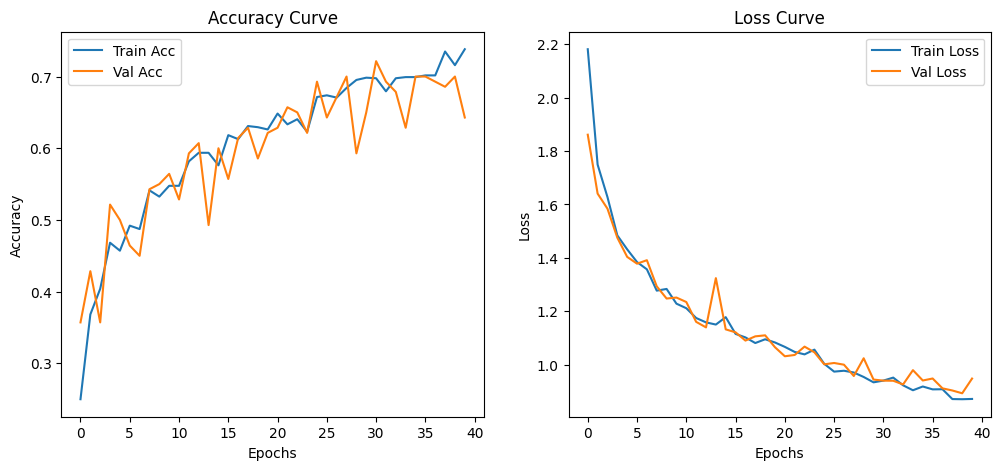


Test Classification Report:
               precision    recall  f1-score   support

         Aush     1.0000    0.8000    0.8889        60
        BR-28     0.7750    0.5167    0.6200        60
        BR-29     0.5714    0.4667    0.5138        60
      Miniket     0.7887    0.9333    0.8550        60
       Swarna     0.8548    0.8833    0.8689        60
 Katari Najir     0.6452    0.6667    0.6557        60
    Ghee Bhog     0.5476    0.7667    0.6389        60
    Chinigura     0.6452    0.6667    0.6557        60
Katari Siddho     0.9206    0.9667    0.9431        60
        Beroi     0.7627    0.7500    0.7563        60

     accuracy                         0.7417       600
    macro avg     0.7511    0.7417    0.7396       600
 weighted avg     0.7511    0.7417    0.7396       600



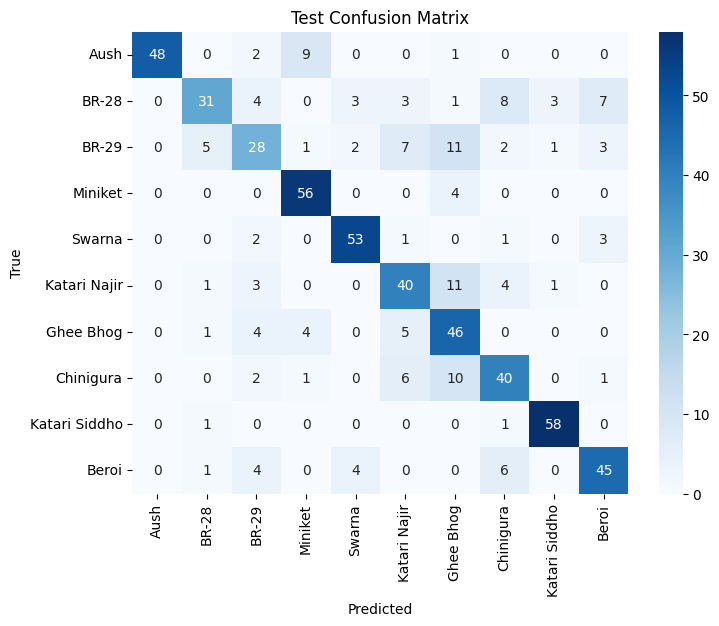

Aush Accuracy: 0.8000
BR-28 Accuracy: 0.5167
BR-29 Accuracy: 0.4667
Miniket Accuracy: 0.9333
Swarna Accuracy: 0.8833
Katari Najir Accuracy: 0.6667
Ghee Bhog Accuracy: 0.7667
Chinigura Accuracy: 0.6667
Katari Siddho Accuracy: 0.9667
Beroi Accuracy: 0.7500
Macro Precision: 0.7511
Macro Recall: 0.7417
Macro F1-score: 0.7396
Aush: Precision=1.0000, Recall=0.8000, F1=0.8889
BR-28: Precision=0.7750, Recall=0.5167, F1=0.6200
BR-29: Precision=0.5714, Recall=0.4667, F1=0.5138
Miniket: Precision=0.7887, Recall=0.9333, F1=0.8550
Swarna: Precision=0.8548, Recall=0.8833, F1=0.8689
Katari Najir: Precision=0.6452, Recall=0.6667, F1=0.6557
Ghee Bhog: Precision=0.5476, Recall=0.7667, F1=0.6389
Chinigura: Precision=0.6452, Recall=0.6667, F1=0.6557
Katari Siddho: Precision=0.9206, Recall=0.9667, F1=0.9431
Beroi: Precision=0.7627, Recall=0.7500, F1=0.7563


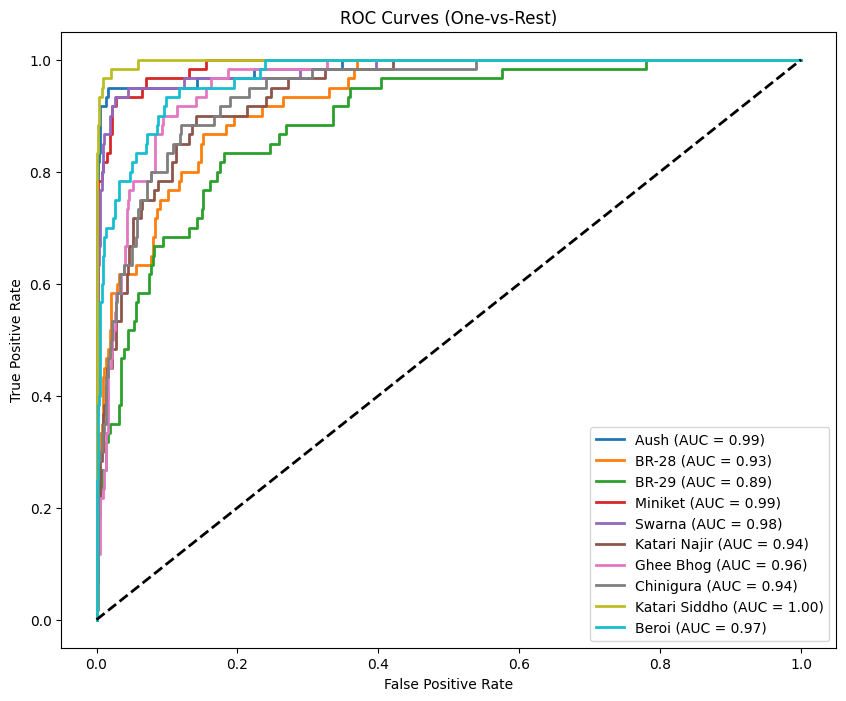

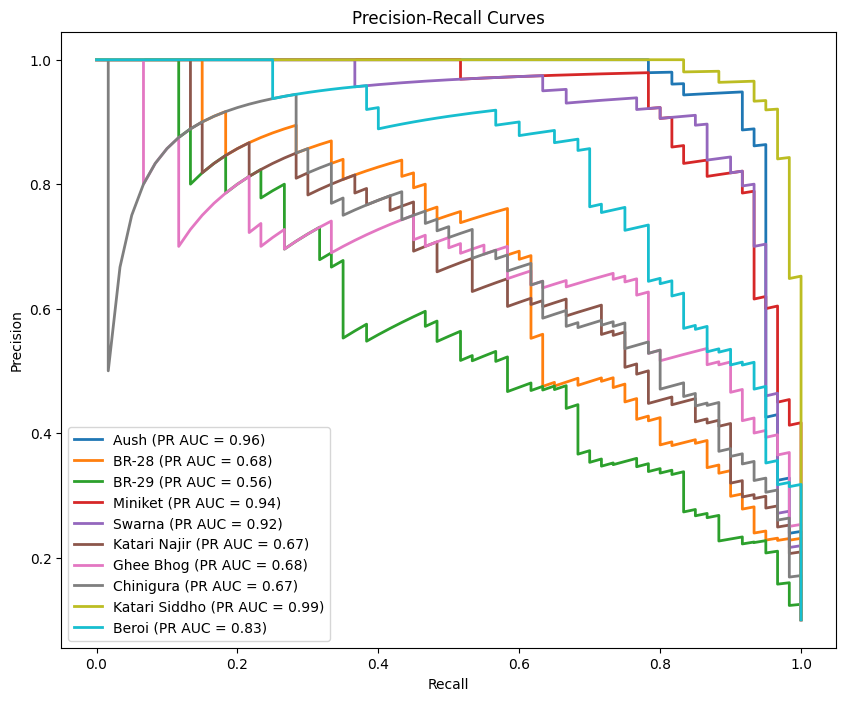

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 13.46 sec
Inference time per sample: 0.022426 sec

Most confused class pairs:
Aush is most often confused with Miniket (9 samples)
BR-28 is most often confused with Chinigura (8 samples)
BR-29 is most often confused with Ghee Bhog (11 samples)
Miniket is most often confused with Ghee Bhog (4 samples)
Swarna is most often confused with Beroi (3 samples)
Katari Najir is most often confused with Ghee Bhog (11 samples)
Ghee Bhog is most often confused with Katari Najir (5 samples)
Chinigura is most often confused with Ghee Bhog (10 samples)
Katari Siddho is most often confused with BR-28 (1 samples)
Beroi is most often confused with Chinigura (6 samples)


In [20]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_70_30'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)  # ResNet50 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: ResNet50
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, resnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, resnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

In [21]:
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.010922 seconds


In [22]:
# Calculate and print the number of parameters
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 24,641,930
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Found 1260 images belonging to 10 classes.
Found 140 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 - 70s - 2s/step - accuracy: 0.5548 - loss: 1.4287 - val_accuracy: 0.6929 - val_loss: 0.9172 - learning_rate: 1.0000e-03
Epoch 2/40
40/40 - 13s - 317ms/step - accuracy: 0.7825 - loss: 0.6448 - val_accuracy: 0.8286 - val_loss: 0.5113 - learning_rate: 1.0000e-03
Epoch 3/40
40/40 - 13s - 318ms/step - accuracy: 0.8460 - loss: 0.4782 - val_accuracy: 0.8500 - val_loss: 0.4570 - learning_rate: 1.0000e-03
Epoch 4/40
40/40 - 13s - 314ms/step - accuracy: 0.8563 - loss: 0.4185 - val_accuracy: 0.8929 - val_loss: 0.3843 - learning_rate: 1.0000e-03
Epoch 5/40
40/40 - 13s - 314ms/step - accuracy: 0.8722 - loss: 0.3909 - val_accuracy: 0.9071 - val_loss: 0.3277 - learning_rate: 1.0000e-03
Epoch 6/40
40/40 - 12s - 311ms/step - accuracy: 0.8929 - loss: 0.3147 - val_accuracy: 0.9071 - val_loss: 0.3703 - learning_rate: 1.0000e-03
Epoch 7/40
40/40 - 12s - 309ms/step - accuracy: 0.8913 - loss: 0.3089 - val_accuracy: 0.9000 - val_loss: 0.3254 - learning_rate: 1.0000e-03
Epoch 8/40
40/40 - 12s 

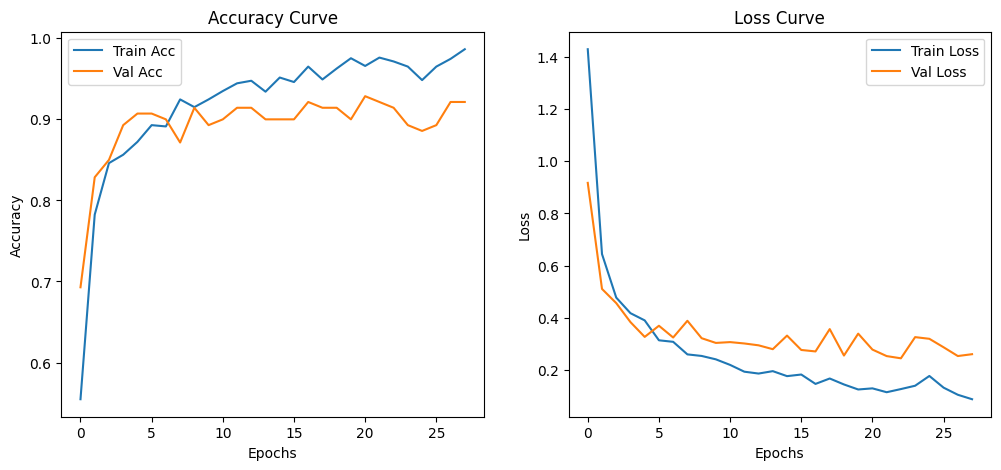


Test Classification Report:
               precision    recall  f1-score   support

         Aush     0.9833    0.9833    0.9833        60
        BR-28     0.8772    0.8333    0.8547        60
        BR-29     0.8814    0.8667    0.8739        60
      Miniket     0.9836    1.0000    0.9917        60
       Swarna     0.9833    0.9833    0.9833        60
 Katari Najir     0.9483    0.9167    0.9322        60
    Ghee Bhog     0.8793    0.8500    0.8644        60
    Chinigura     0.8382    0.9500    0.8906        60
Katari Siddho     0.9672    0.9833    0.9752        60
        Beroi     0.9483    0.9167    0.9322        60

     accuracy                         0.9283       600
    macro avg     0.9290    0.9283    0.9282       600
 weighted avg     0.9290    0.9283    0.9282       600



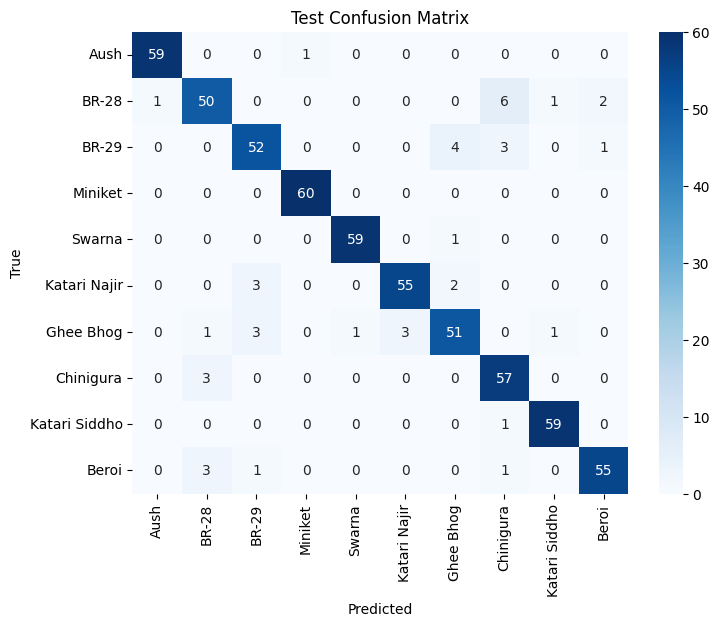

Aush Accuracy: 0.9833
BR-28 Accuracy: 0.8333
BR-29 Accuracy: 0.8667
Miniket Accuracy: 1.0000
Swarna Accuracy: 0.9833
Katari Najir Accuracy: 0.9167
Ghee Bhog Accuracy: 0.8500
Chinigura Accuracy: 0.9500
Katari Siddho Accuracy: 0.9833
Beroi Accuracy: 0.9167


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 29.80 sec
Inference time per sample: 0.049675 sec


In [24]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data_70_30'
dataset_dir = "/root/.cache/kagglehub/datasets/nuranfarhanaprova/processed-rice-varieties-of-bangladesh/versions/1/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

In [25]:
# Calculate and print the number of parameters
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 546,314
Non-Trainable Parameters: 4,269,716


Macro Precision: 0.9290
Macro Recall: 0.9283
Macro F1-score: 0.9282

Per-Class Metrics:
Aush: Precision=0.9833, Recall=0.9833, F1=0.9833
BR-28: Precision=0.8772, Recall=0.8333, F1=0.8547
BR-29: Precision=0.8814, Recall=0.8667, F1=0.8739
Miniket: Precision=0.9836, Recall=1.0000, F1=0.9917
Swarna: Precision=0.9833, Recall=0.9833, F1=0.9833
Katari Najir: Precision=0.9483, Recall=0.9167, F1=0.9322
Ghee Bhog: Precision=0.8793, Recall=0.8500, F1=0.8644
Chinigura: Precision=0.8382, Recall=0.9500, F1=0.8906
Katari Siddho: Precision=0.9672, Recall=0.9833, F1=0.9752
Beroi: Precision=0.9483, Recall=0.9167, F1=0.9322


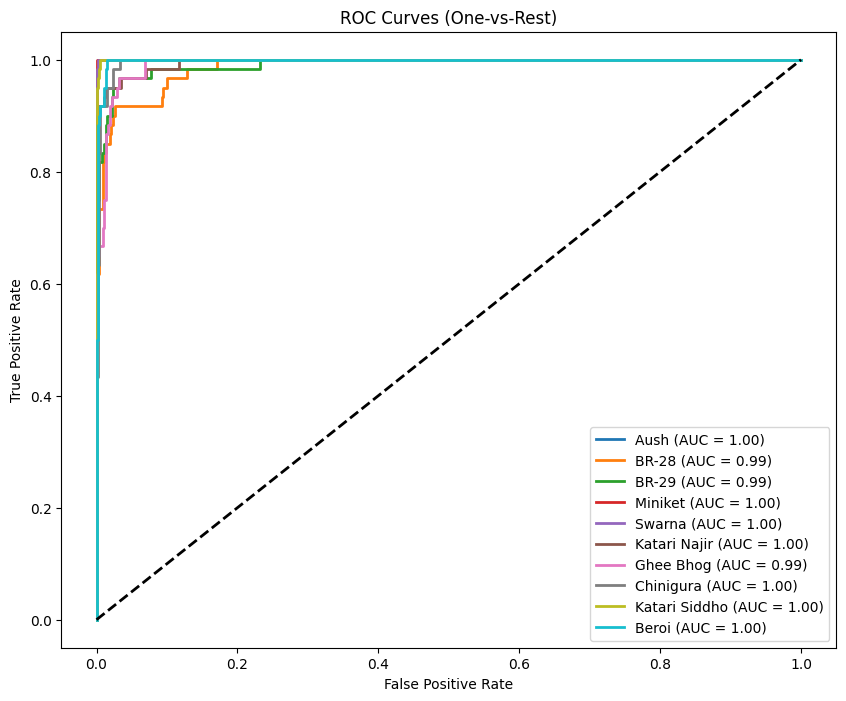

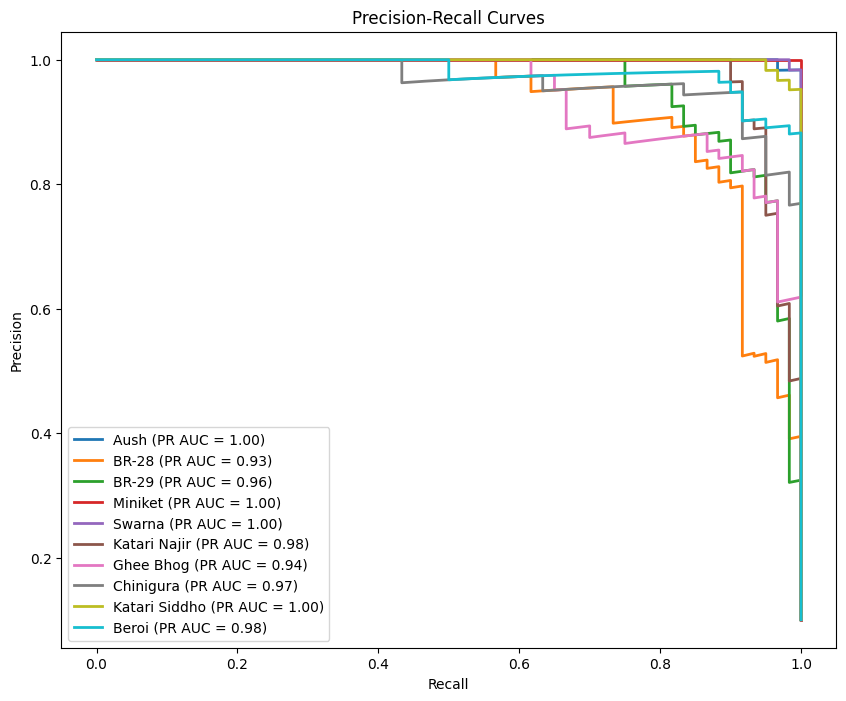


Most Confused Class Pairs:
Aush is most often confused with Miniket (1 samples)
BR-28 is most often confused with Chinigura (6 samples)
BR-29 is most often confused with Ghee Bhog (4 samples)
Miniket is most often confused with Aush (0 samples)
Swarna is most often confused with Ghee Bhog (1 samples)
Katari Najir is most often confused with BR-29 (3 samples)
Ghee Bhog is most often confused with BR-29 (3 samples)
Chinigura is most often confused with BR-28 (3 samples)
Katari Siddho is most often confused with Chinigura (1 samples)
Beroi is most often confused with BR-28 (3 samples)


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}\n")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

print("Per-Class Metrics:")
for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC Curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Failure Modes: Most Confused Class Pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost Confused Class Pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # Ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")
